# Suicide and Depression Detection

The dataset is a collection of posts from "SuicideWatch" and "depression" subreddits of the Reddit platform. The posts are collected using Pushshift API. All posts that were made to "SuicideWatch" from Dec 16, 2008(creation) till Jan 2, 2021, were collected while "depression" posts were collected from Jan 1, 2009, to Jan 2, 2021.

It's worth noting that working with datasets related to mental health can be sensitive and challenging, as it involves handling personal and potentially sensitive information. It's important to approach this data with care and respect, and to ensure that any research or analysis is conducted in an ethical and responsible manner.

In [2]:
# for pip installs
# pip install seaborn
# pip install --upgrade pip

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2,f_classif
from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier,GradientBoostingClassifier,BaggingClassifier
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

import pickle
import string

# Text Processing libraries
import nltk
from nltk.stem import PorterStemmer

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
data = pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


# Data Preprocessing

In [5]:
data.shape

(232074, 3)

- The given dataset contain more than **2 lakh** rows.
- It takes take significant time and resources, as it involves optimizing the parameters of the model and processing the data iteratively.
- So I will take 10000 data points which will help to reduce complexity.

In [6]:
df = data.sample(n=10000, random_state=42)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 74414 to 224640
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   text        10000 non-null  object
 2   class       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 312.5+ KB


In [8]:
df['Unnamed: 0'].is_unique

True

In [9]:
df.drop(columns = 'Unnamed: 0',inplace=True)

In [10]:
df.head()

,text,class
74414,I Don't know?7? Months self harm free and the ...,suicide
149516,I HAVE TO START BECOMING RICH I HAVE TO START ...,non-suicide
12484,"A poem (haiku) for u/Me-Game-Dev hi, hello hel...",non-suicide
14043,I've honestly got no idea what to do anymore.I...,suicide
30673,Do you ever just cry? Like you just think abou...,non-suicide


In [11]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [12]:
df.duplicated().sum()

0

# Data Visualisation

In [13]:
# classCnt = df['class'].value_counts()
# print(classCnt)

# plt.figure(figsize=((20,5)))

# plt.subplot(1,2,1)
# sns.countplot(df,x='class')

# plt.subplot(1,2,2)
# plt.pie(classCnt,labels = classCnt.index,autopct='%.0f%%')

# plt.show()

# Text Preprocessing

## Lowering the Text
- Changing the case involves converting all text to lowercase or uppercase so that all word strings follow a consistent format. 
- Lowercasing is the more frequent choice in NLP software.

In [14]:
df['text']= df['text'].str.lower()

## Remove Punctuations
- Text preprocessing involves various techniques to clean and transform raw text data into a more suitable format for analysis.
- Removing punctuation is one of the most commonly used preprocessing techniques, as punctuation marks do not usually add much semantic value to the text and can interfere with downstream NLP tasks.
-  String library of Python contains some pre-defined list of punctuations such as **‘!”#$%&'()*+,-./:;?@[\]^_`{|}~’**

In [15]:
df['text'] = df['text'].str.replace(r'[^\w\s]+', '',regex = True)

## Stop word removal

- Stopwords are the most commonly occurring words in a language, such as "the", "and", "a", "an", "in", "to", etc. 
- These words have very little semantic value and are often used to connect meaningful words in a sentence. 
- In many natural language processing (NLP) tasks, stopwords can be removed without affecting the meaning of the text, and doing so can actually improve the performance of the NLP models.

In [16]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## Tokenization   
- The tokenization stage involves converting a sentence into a stream of words, also called “tokens.”
- Tokens are usually words, but they can also be phrases, symbols, or other meaningful units of text.

In [17]:
df['text'] = df['text'].apply(lambda x:nltk.word_tokenize(x))

## Stemming
- The term word stem is borrowed from linguistics and used to refer to the base or root form of a word.
- Stemming is the process of converting all words to their base form, or stem. 

In [18]:
ps = PorterStemmer()
df['text'] = df['text'].apply(lambda x : [ps.stem(i) for i in x])

In [19]:
df['text']=df['text'].apply(lambda x : ' '.join(x))

In [20]:
df.head()

,text,class
74414,dont know7 month self harm free urg get strong...,suicide
149516,start becom rich start compani becom 16 afford...,non-suicide
12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
14043,ive honestli got idea anymoreit feel everyon f...,suicide
30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [21]:
# Saved the cleaned dataset.
df.to_csv('cleaned_dataset.csv')

In [22]:
dfnew = pd.read_csv('cleaned_dataset.csv')
dfnew.head()

,Unnamed: 0,text,class
0,74414,dont know7 month self harm free urg get strong...,suicide
1,149516,start becom rich start compani becom 16 afford...,non-suicide
2,12484,poem haiku umegamedev hi hello hello stop fuck...,non-suicide
3,14043,ive honestli got idea anymoreit feel everyon f...,suicide
4,30673,ever cri like think unfair life cri cant cri e...,non-suicide


In [23]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10000 non-null  int64 
 1   text        9999 non-null   object
 2   class       10000 non-null  object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [24]:
ind = dfnew[dfnew['text'].isnull()].index

In [25]:
df.iloc[ind]

,text,class
102482,,suicide


- **'text'** column contains None values.
- It may contain puctuations or emojies.
- So I am going to drop that rows

In [26]:
dfnew.dropna(inplace=True)

# Machine Learning - Model Selection

In [27]:
x,y = dfnew['text'],dfnew['class']

## TF-IDF Vectorizer

In [28]:
vectorizer = TfidfVectorizer(min_df=50,max_features=5000)
x =  vectorizer.fit_transform(x).toarray()

In [29]:
# Save the model
with open('tfidf.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)    

In [30]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.30,random_state=5)

In [31]:
X_train.shape,X_test.shape

((6999, 1320), (3000, 1320))

## Naive Bayes (Voting Classifier)

In [32]:
nb = GaussianNB()
nb2 = BernoulliNB()
nb3 = MultinomialNB()
VotingClassifiers = VotingClassifier(estimators=[('GaussianNB', nb),('BernoulliNB',nb2), ('MultinomialNB', nb3)], voting = 'soft')
VotingClassifiers.fit(X_train, y_train)
print('Training score:',VotingClassifiers.score(X_train, y_train))
print('Testing score:',VotingClassifiers.score(X_test,y_test))

Training score: 0.899271324474925
Testing score: 0.8753333333333333


              precision    recall  f1-score   support

 non-suicide       0.88      0.88      0.88      1542
     suicide       0.87      0.87      0.87      1458

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



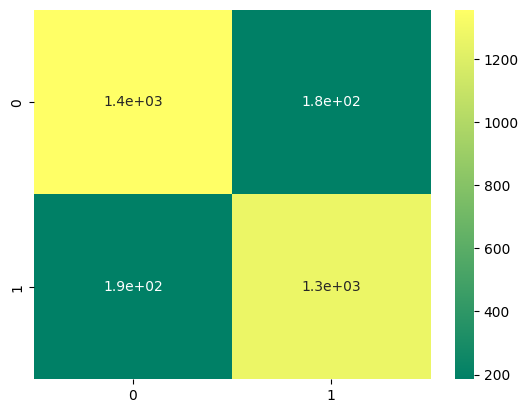

In [33]:
y_act=y_test
y_pred=VotingClassifiers.predict(X_test)
sns.heatmap(confusion_matrix(y_act,y_pred),annot=True,cmap='summer')
print(classification_report(y_act,y_pred))

In [34]:
# Save the model
with open('VotingClassifier.pkl', 'wb') as f:
    pickle.dump(VotingClassifiers, f)


In [35]:


def sui2risk(word):
    if word == 'suicide':
        return 'risk'
    elif word == 'non-suicide':
        return 'not_risk'
    else:
        return word

def finetune(sui):
    return [sui2risk(s) for s in sui]


In [42]:
# use the saved model to make predictions
with open('VotingClassifier.pkl', 'rb') as f:
    model = pickle.load(f)

# make a prediction on user input
input1 = "Hi there. Let's go out!"
input2 = "I'm feeling sad today."
input3 = "I want to kill myself."
input4 = "The world would be a better place without me"
inputs = [input1, input2, input3, input4]
vec_inputs = vectorizer.transform(inputs).toarray()
predictions = model.predict(vec_inputs)
print("User inputs:")
print(inputs)
print("Predictions:")
print(finetune(predictions))

User inputs:
["Hi there. Let's go out!", "I'm feeling sad today.", 'I want to kill myself.', 'The world would be a better place without me']
Predictions:
['not_risk', 'not_risk', 'risk', 'risk']


In [59]:
import json

with open('msg.json','r') as file:
    data=json.load(file)
    
texts=[]
for text in data:
    texts.append(text['text'])
inputs = vectorizer.transform(texts).toarray()
predictions = model.predict(inputs)
print("User inputs:")
print(texts)
print("Predictions:")
print(finetune(predictions))


User inputs:
['hi', "Hi there. Let's go out!", "I'm feeling sad today.", 'I want to kill myself.', 'The world would be a better place without me.']
Predictions:
['not_risk', 'not_risk', 'not_risk', 'risk', 'risk']
